In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, udf, when
from pyspark.sql.types import BooleanType
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier, MultilayerPerceptronClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [10]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Heart Disease Risk Prediction") \
    .getOrCreate()

# Load Dataset
file_path = "heart.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

In [11]:
# Step 1: Data Preprocessing
data = data.fillna({
    'chol': data.select(mean(col("chol"))).first()[0],  # Fill missing Cholesterol with mean
    'thal': data.select("thal").groupBy("thal").count().orderBy("count", ascending=False).first()[0]  # Most common value
})

In [12]:
# Convert Categorical Variables
indexers = [
    StringIndexer(inputCol="cp", outputCol="cp_index"),
    StringIndexer(inputCol="restecg", outputCol="restecg_index"),
    StringIndexer(inputCol="thal", outputCol="thal_index")
]
for indexer in indexers:
    data = indexer.fit(data).transform(data)

In [13]:
# Feature Scaling
assembler = VectorAssembler(
    inputCols=["age", "trestbps", "chol", "thalach", "oldpeak"],
    outputCol="features_assembled"
)
data = assembler.transform(data)
scaler = StandardScaler(inputCol="features_assembled", outputCol="features_scaled", withStd=True, withMean=True)
data = scaler.fit(data).transform(data)

In [14]:
# Final Dataset Preparation
feature_cols = ["features_scaled", "cp_index", "restecg_index", "thal_index", "fbs", "exang"]
assembler_final = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler_final.transform(data).select("features", col("target").alias("label"))

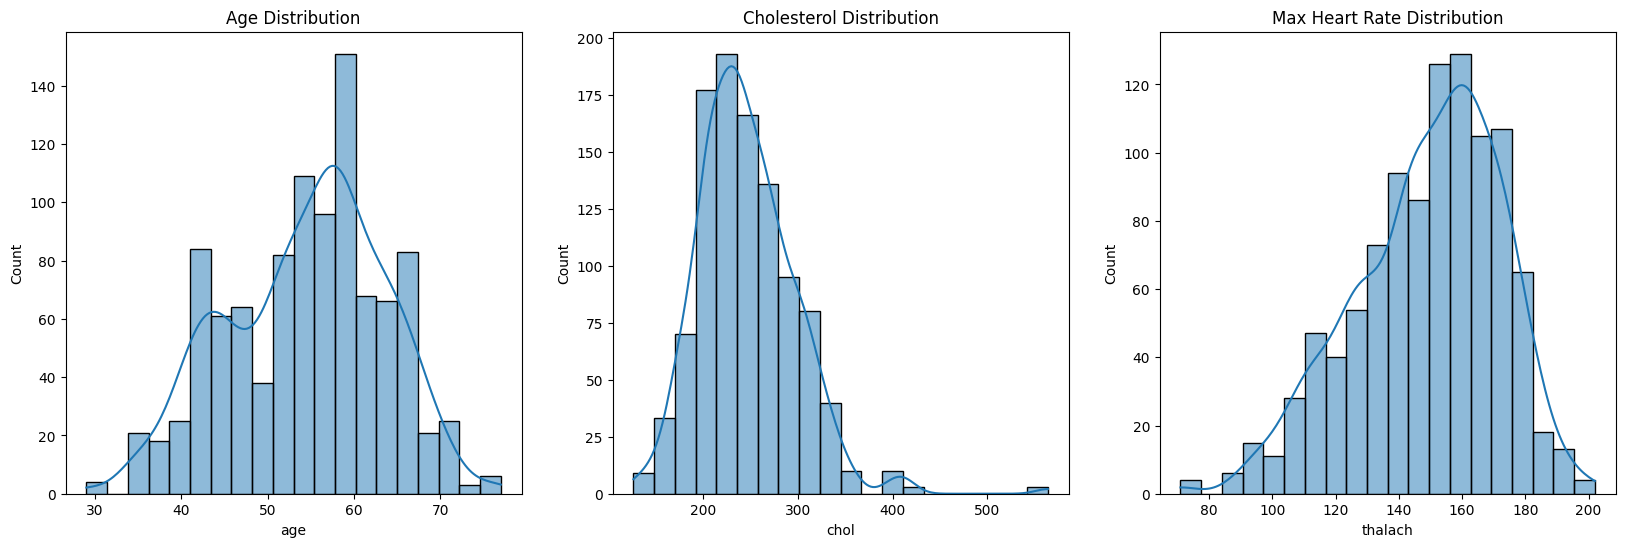

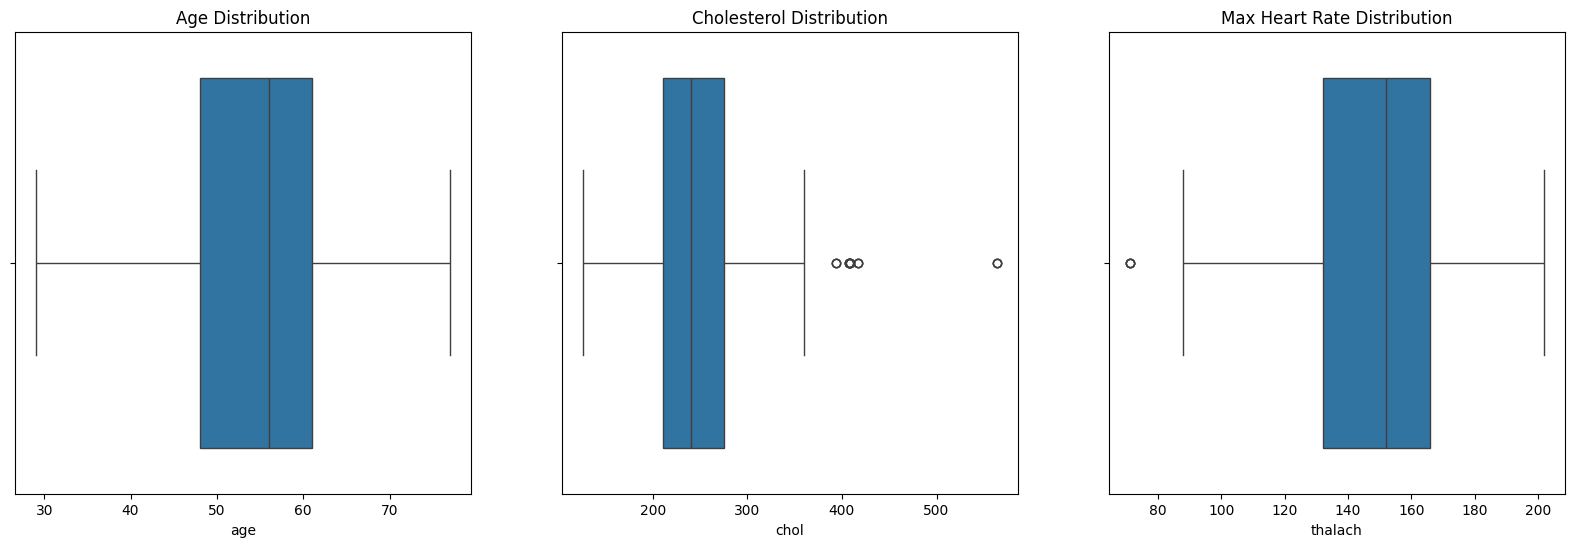

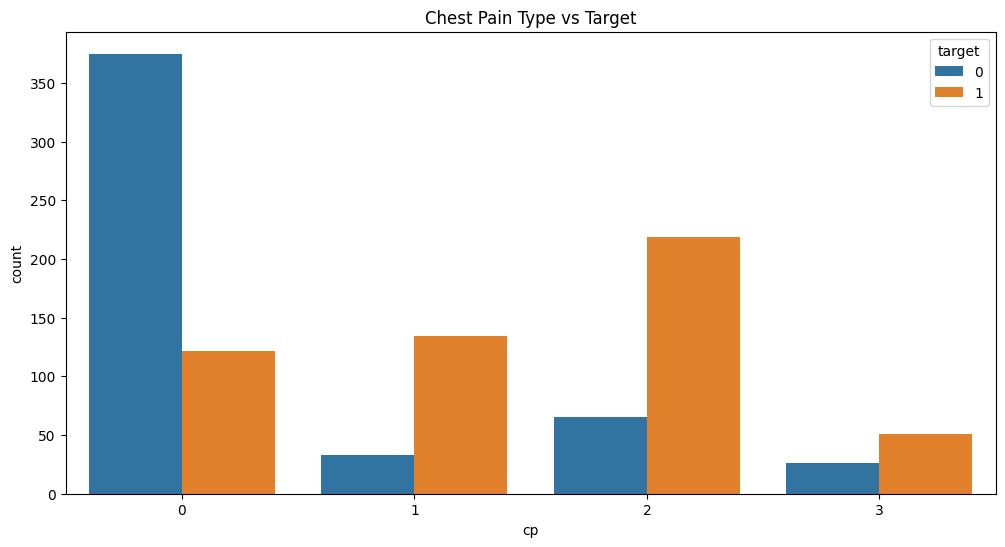

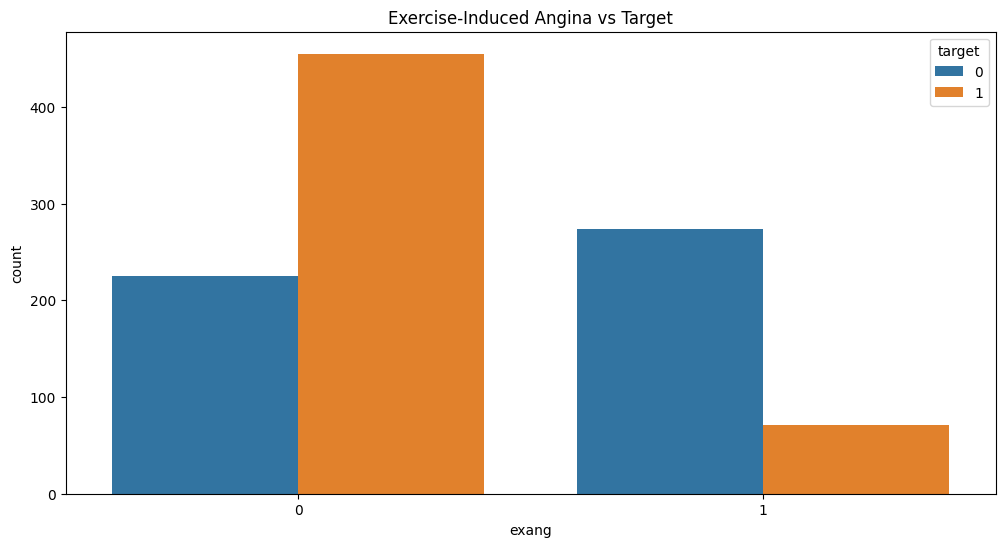

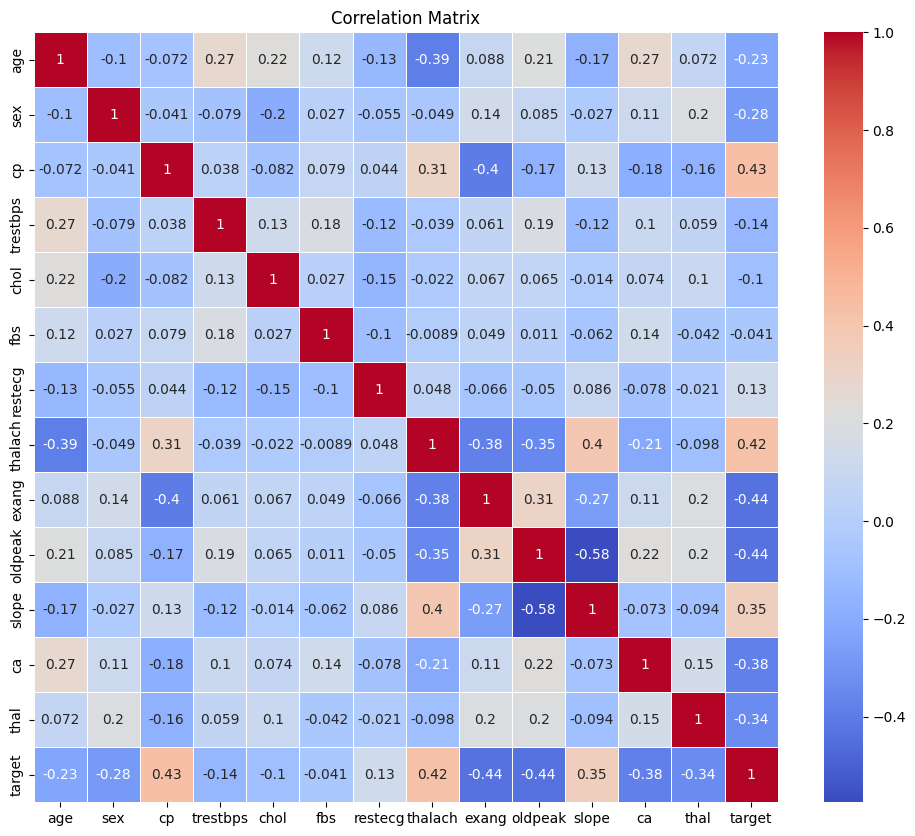

In [15]:
#Task 2
spark = SparkSession.builder \
    .appName("Heart Disease Risk Prediction") \
    .getOrCreate()

# Load Dataset
file_path = "/content/heart.csv"
data_original = spark.read.csv(file_path, header=True, inferSchema=True)

# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = data_original.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for Age, Cholesterol, and Max Heart Rate
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.histplot(pandas_df['age'], bins=20, kde=True)
plt.title('Age Distribution')

plt.subplot(1, 3, 2)
sns.histplot(pandas_df['chol'], bins=20, kde=True)
plt.title('Cholesterol Distribution')

plt.subplot(1, 3, 3)
sns.histplot(pandas_df['thalach'], bins=20, kde=True)
plt.title('Max Heart Rate Distribution')

plt.show()

# Box plots for Age, Cholesterol, and Max Heart Rate
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.boxplot(x=pandas_df['age'])
plt.title('Age Distribution')

plt.subplot(1, 3, 2)
sns.boxplot(x=pandas_df['chol'])
plt.title('Cholesterol Distribution')

plt.subplot(1, 3, 3)
sns.boxplot(x=pandas_df['thalach'])
plt.title('Max Heart Rate Distribution')

plt.show()

# Bar charts to analyze correlation between Target and Chest Pain Type, and Exercise-Induced Angina
plt.figure(figsize=(12, 6))
sns.countplot(x='cp', hue='target', data=pandas_df)
plt.title('Chest Pain Type vs Target')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='exang', hue='target', data=pandas_df)
plt.title('Exercise-Induced Angina vs Target')
plt.show()

# Heatmap for correlation analysis
plt.figure(figsize=(12, 10))
correlation_matrix = pandas_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

               age       sex        cp  trestbps      chol       fbs  \
age       1.000000 -0.103240 -0.071966  0.271121  0.219823  0.121243   
sex      -0.103240  1.000000 -0.041119 -0.078974 -0.198258  0.027200   
cp       -0.071966 -0.041119  1.000000  0.038177 -0.081641  0.079294   
trestbps  0.271121 -0.078974  0.038177  1.000000  0.127977  0.181767   
chol      0.219823 -0.198258 -0.081641  0.127977  1.000000  0.026917   
fbs       0.121243  0.027200  0.079294  0.181767  0.026917  1.000000   
restecg  -0.132696 -0.055117  0.043581 -0.123794 -0.147410 -0.104051   
thalach  -0.390227 -0.049365  0.306839 -0.039264 -0.021772 -0.008866   
exang     0.088163  0.139157 -0.401513  0.061197  0.067382  0.049261   
oldpeak   0.208137  0.084687 -0.174733  0.187434  0.064880  0.010859   
slope    -0.169105 -0.026666  0.131633 -0.120445 -0.014248 -0.061902   
ca        0.271551  0.111729 -0.176206  0.104554  0.074259  0.137156   
thal      0.072297  0.198424 -0.163341  0.059276  0.100244 -0.04

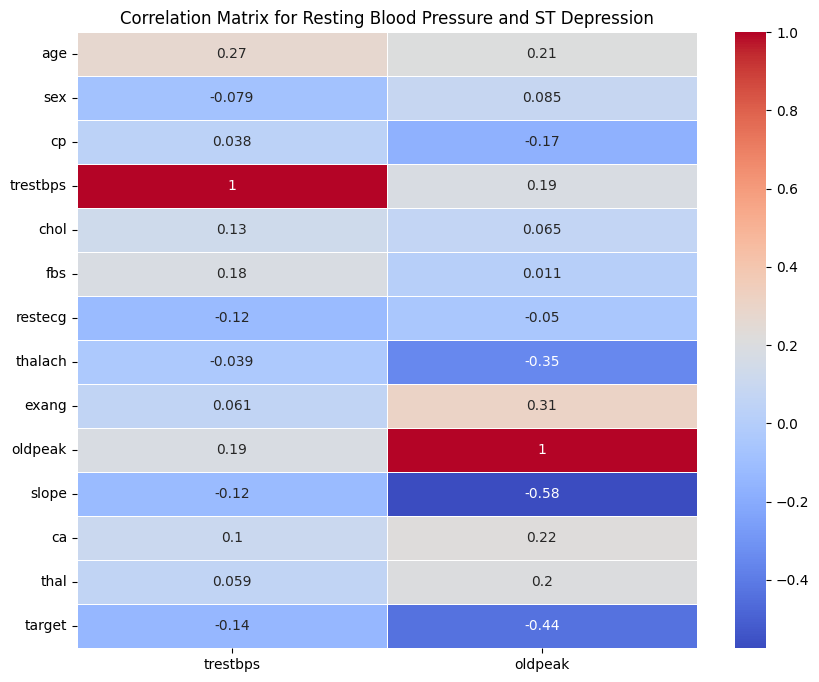

In [16]:
# Compute correlations between numerical features(Task 2)
correlation_matrix = pandas_df.corr()
print(correlation_matrix)

# Checking for multicollinearity among indicators like Resting Blood Pressure and ST Depression
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['trestbps', 'oldpeak']], annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Resting Blood Pressure and ST Depression')
plt.show()

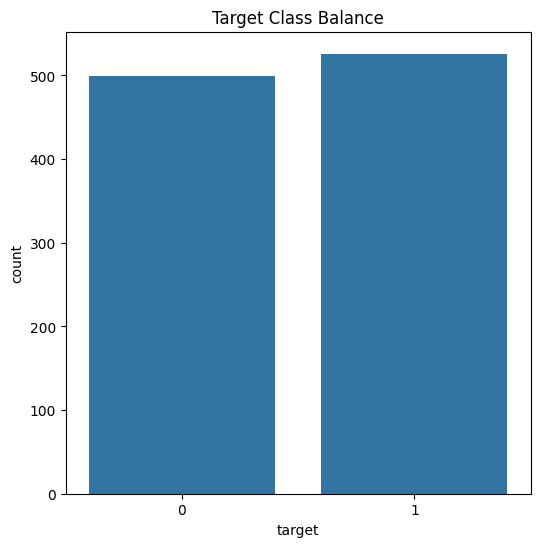

In [17]:
# Assess whether the target classes are balanced
plt.figure(figsize=(6, 6))
sns.countplot(x='target', data=pandas_df)
plt.title('Target Class Balance')
plt.show()

In [18]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# data = data.withColumn("label", when(col("label") == 1, 0).otherwise(1))


# Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="label")
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Decision Tree
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# Gradient-Boosted Trees
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=10)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)

In [19]:
# Step 3: Evaluation
# Binary Classification Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [31]:
models = {
    "Logistic Regression": lr_predictions,
    "Random Forest": rf_predictions,
    "Decision Tree": dt_predictions,
    "Gradient-Boosted Trees": gbt_predictions,
}

In [21]:
# Performance Metrics
for model_name, predictions in models.items():
    auc = evaluator.evaluate(predictions)
    accuracy = multiclass_evaluator.evaluate(predictions)
    print(f"{model_name} AUC: {auc}")
    print(f"{model_name} Accuracy: {accuracy}")

# Precision, Recall, F1-Score
metrics = ["weightedPrecision", "weightedRecall", "f1"]
for model_name, predictions in models.items():
    print(f"\n{model_name} Metrics:")
    for metric in metrics:
        score = multiclass_evaluator.setMetricName(metric).evaluate(predictions)
        print(f"{metric}: {score}")

Logistic Regression AUC: 0.8417560700169396
Logistic Regression Accuracy: 0.757396449704142
Random Forest AUC: 0.9497459062676453
Random Forest Accuracy: 0.863905325443787
Decision Tree AUC: 0.9388057594579333
Decision Tree Accuracy: 0.8994082840236687
Gradient-Boosted Trees AUC: 0.9902597402597402
Gradient-Boosted Trees Accuracy: 0.9349112426035503

Logistic Regression Metrics:
weightedPrecision: 0.7626114752114279
weightedRecall: 0.7573964497041421
f1: 0.757855716723107

Random Forest Metrics:
weightedPrecision: 0.8674034110685696
weightedRecall: 0.863905325443787
f1: 0.8641727676929762

Decision Tree Metrics:
weightedPrecision: 0.9048918945356216
weightedRecall: 0.8994082840236686
f1: 0.8995987118120201

Gradient-Boosted Trees Metrics:
weightedPrecision: 0.9383745214061956
weightedRecall: 0.9349112426035503
f1: 0.9350391497662061


In [22]:
# Confusion Matrix
def confusion_matrix(predictions):
    predictions.groupBy("label", "prediction").count().show()

for model_name, predictions in models.items():
    print(f"\n{model_name} Confusion Matrix:")
    confusion_matrix(predictions)


Logistic Regression Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   16|
|    0|       0.0|   67|
|    1|       1.0|   61|
|    0|       1.0|   25|
+-----+----------+-----+


Random Forest Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    8|
|    0|       0.0|   77|
|    1|       1.0|   69|
|    0|       1.0|   15|
+-----+----------+-----+


Decision Tree Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    4|
|    0|       0.0|   79|
|    1|       1.0|   73|
|    0|       1.0|   13|
+-----+----------+-----+


Gradient-Boosted Trees Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    2|
|    0|       0.0|   83|
|    1|       1.0|   75|
|    0|       1.0|    9|
+-----+----------+-----+



In [23]:
# Step 4: Hyperparameter Tuning (Random Forest)
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

crossval = CrossValidator(estimator=rf, estimatorParamMaps=param_grid,
                          evaluator=evaluator, numFolds=5)

cv_model = crossval.fit(train_data)
cv_predictions = cv_model.transform(test_data)

cv_auc = evaluator.evaluate(cv_predictions)
cv_accuracy = multiclass_evaluator.evaluate(cv_predictions)
print(f"\nTuned Random Forest AUC: {cv_auc}")
print(f"Tuned Random Forest Accuracy: {cv_accuracy}")


Tuned Random Forest AUC: 0.9997176736307172
Tuned Random Forest Accuracy: 0.9881765177623165


In [24]:
# Feature Importance (Random Forest)
rf_feature_importances = cv_model.bestModel.featureImportances
print("\nFeature Importances:")
for idx, importance in enumerate(rf_feature_importances):
    print(f"Feature {idx}: {importance}")

# Stop SparkSession
pandas_df = data.toPandas()


Feature Importances:
Feature 0: 0.15035497440746387
Feature 1: 0.08882284124562248
Feature 2: 0.08168887684841776
Feature 3: 0.20217225705152259
Feature 4: 0.1359713125299525
Feature 5: 0.18276580691134808
Feature 6: 0.019857623025715452
Feature 7: 0.0985646242552251
Feature 8: 0.0073610446516556806
Feature 9: 0.03244063907307653


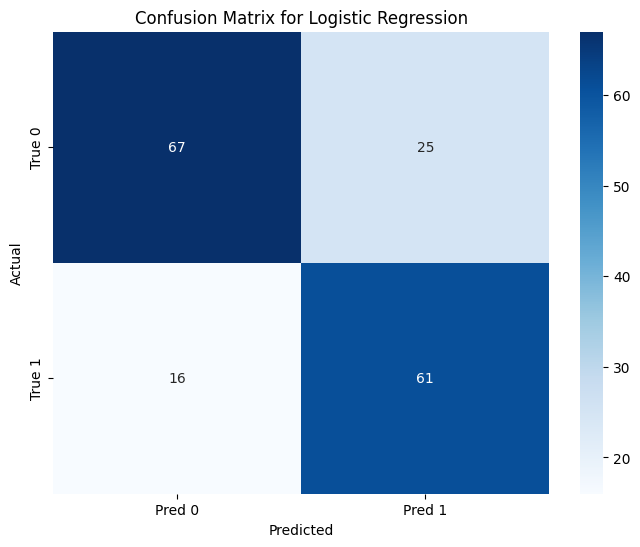

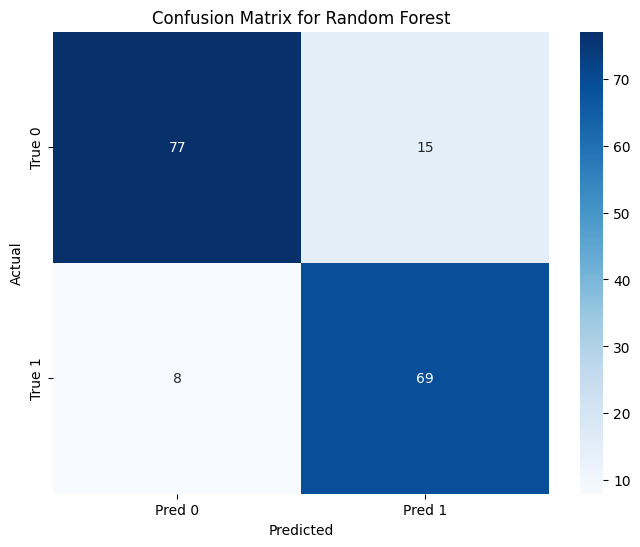

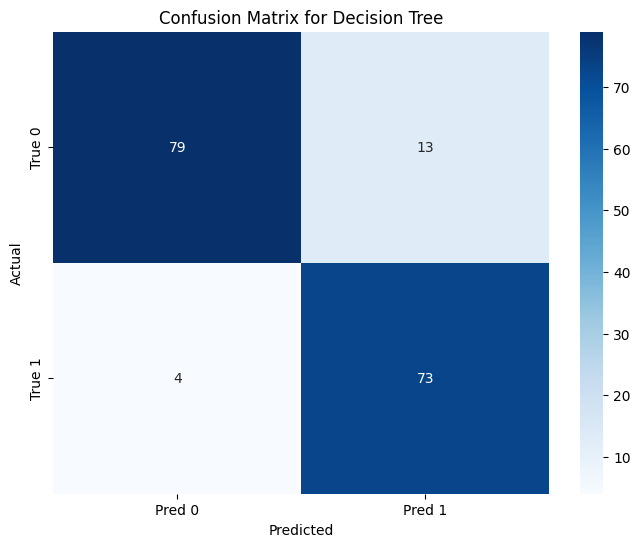

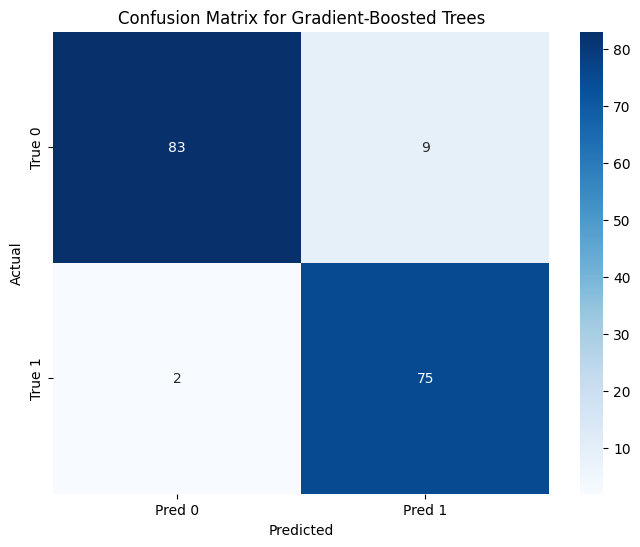

In [25]:
#Task 5(Confusion matrix)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(predictions, model_name):
    y_true = predictions.select('label').collect()
    y_pred = predictions.select('prediction').collect()

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrix for each model
for model_name, predictions in models.items():
    plot_confusion_matrix(predictions, model_name)

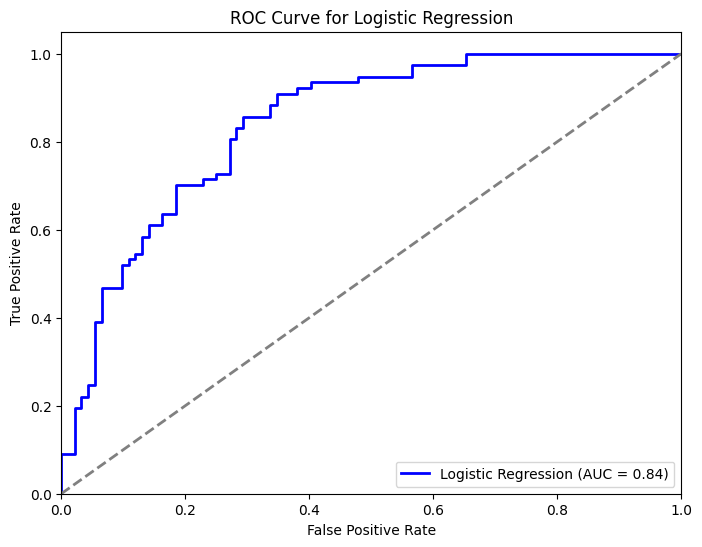

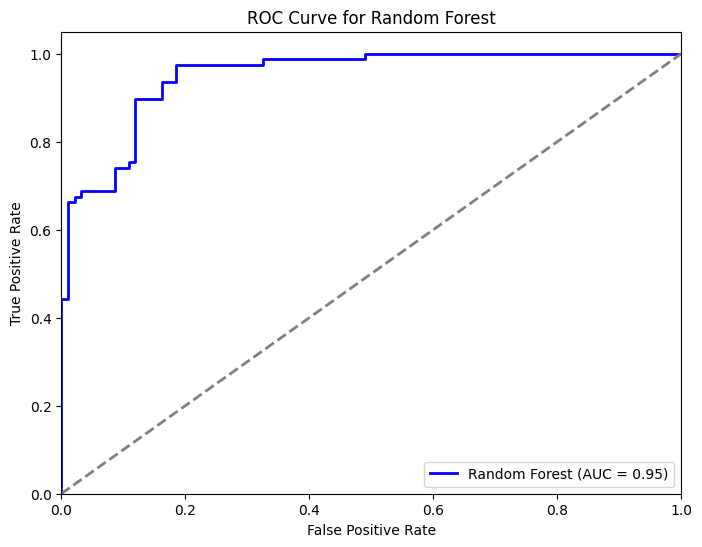

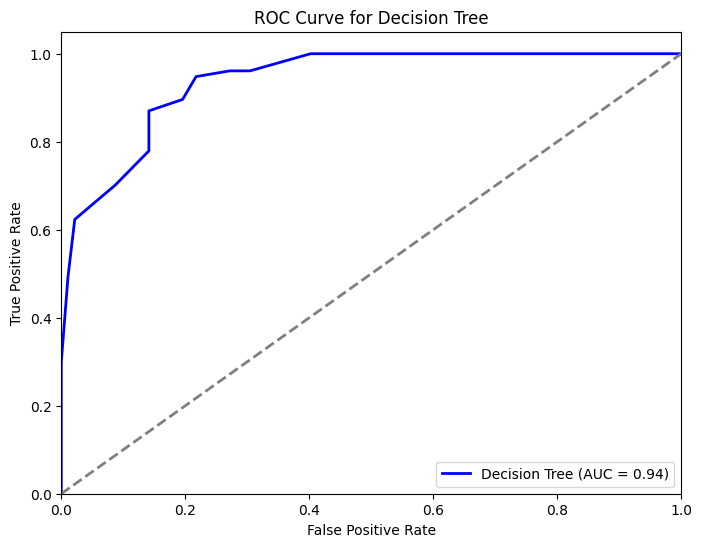

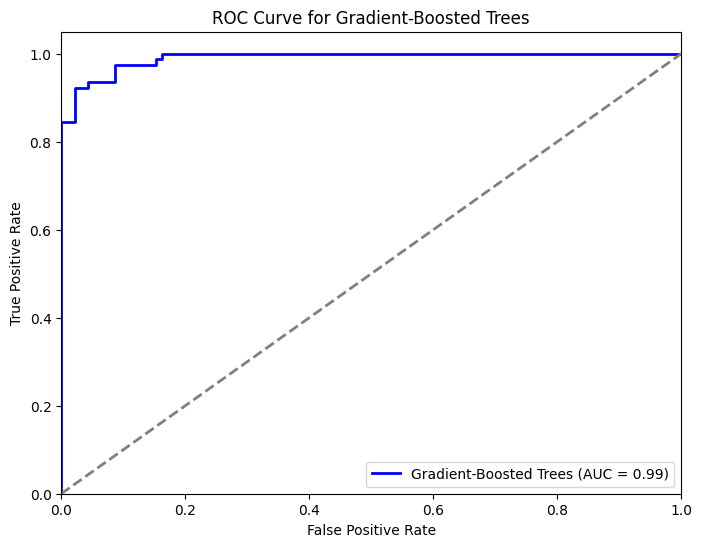

In [26]:
#Task 5(ROC Curve)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')

def plot_roc_curve(predictions, model_name):
    # Ensure the rawPrediction column is an array
    predictions = predictions.withColumn('rawPredictionArray', vector_to_array(col('rawPrediction')))

    # Collect the raw prediction values and labels
    y_true = predictions.select('label').collect()
    y_score = predictions.select('rawPredictionArray').collect()

    y_true = [row[0] for row in y_true]
    y_score = [row[0][1] for row in y_score]

    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curve for each model
for model_name, predictions in models.items():
    plot_roc_curve(predictions, model_name)


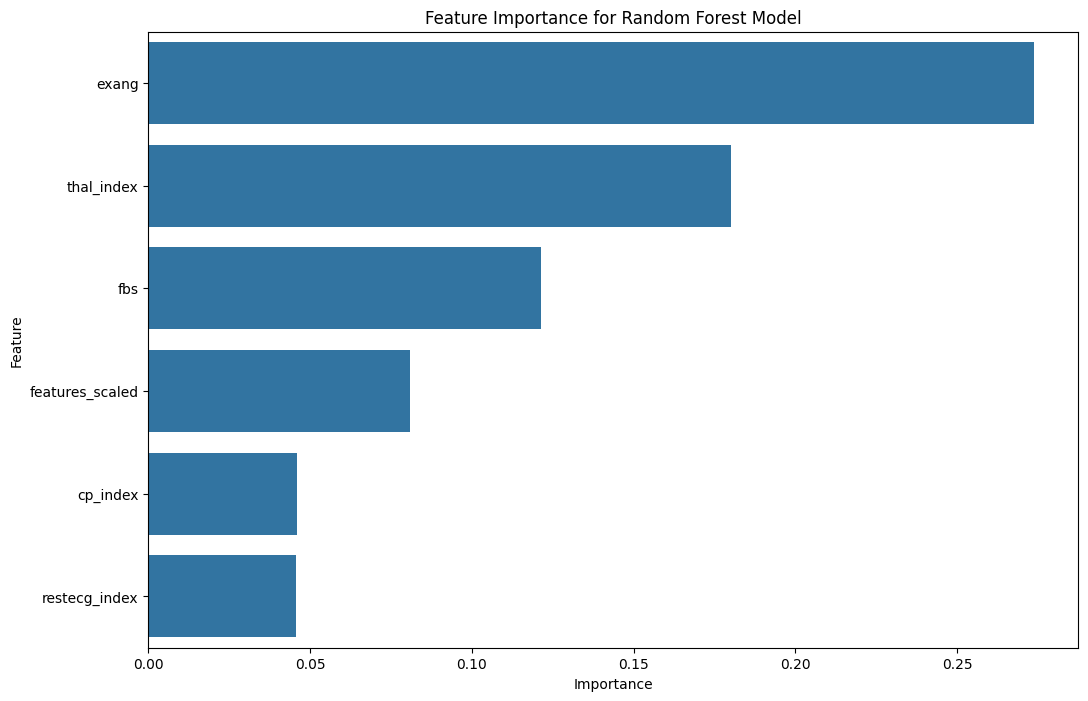

In [27]:
#Task 5(Feature Importance)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the Random Forest model
rf_feature_importances = rf_model.featureImportances

# Create a Pandas DataFrame for the feature importances
feature_importance_df = pd.DataFrame(list(zip(feature_cols, rf_feature_importances)), columns=['Feature', 'Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
